# Sensor Fusion

In [1]:
import jax.numpy as jnp
import jax.numpy.linalg as JLA
from scipy.linalg import block_diag
from scipy.stats import norm
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns

try:
    from probml_utils import pyprobml_utils as pml
except ModuleNotFoundError:
    %pip install git+https://github.com/probml/probml-utils.git
    from probml_utils import pyprobml_utils as pml

from probml_utils import savefig, latexify, is_latexify_enabled

In [2]:
latexify(width_scale_factor=3, font_size=8, fig_height=1.2)

C:\Users\NITISH SHARMA\.pyenv\pyenv-win\versions\3.9.10\lib\site-packages\probml_utils\plotting.py:26: UserWarning: LATEXIFY environment variable not set, not latexifying
  warnings.warn("LATEXIFY environment variable not set, not latexifying")


In [3]:
def cov_to_pts(cov):
    """
    Helper function to get covariance interval for plotting

    Args:
    ----------
    cov : JAX Array
        Covariance Matrix

    Returns:
    ----------
    cov_int : JAX Array
        Covariance Interval
    """
    # Choose points between (0,2*pi)
    circle_pts = jnp.linspace(0, 2 * jnp.pi, 100)

    # Make a cirle
    circle = jnp.asarray([jnp.cos(circle_pts), jnp.sin(circle_pts)])

    # Singular Value Decomp
    [u, s, v] = JLA.svd(cov)
    confidence_intr = u * 2.447 * jnp.sqrt(s)  # 95% confidence

    # Covariance Interval
    cov_int = jnp.dot(confidence_intr, circle)

    return cov_int

In [4]:
def gauss_plot2d(plot_dict: dict, fig_pos: int, save_name: str = "", i: int = 1) -> None:
    """
    Plot data

    Args:
    ----------
    plot_dict :
        Data required for plotting

    fig_pos :
        Position of figure

    save_name :
        Name of saved image

    Returns:
    ----------
    None
    """

    # Plot the points and confidence intervals
    plt.figure()

    for key, value in plot_dict.items():

        plt.scatter(value["mu"][0], value["mu"][1], marker="x", c=value["color"], label=value["label"], s=value["s"])
        plt.plot(
            *cov_to_pts(value["sigma"]) + value["mu"].reshape(2, 1), "-o", c=value["color"], markersize=value["ms"]
        )

    # Add label, legend and display graph
    plt.xlabel("$x$ (observed value)")

    if fig_pos == 0:
        plt.ylabel("$y$ (observed value)")

    # Set number of ticks on axes
    plt.gca().yaxis.set_major_locator(MaxNLocator(6))
    plt.gca().xaxis.set_major_locator(MaxNLocator(6))

    if i == 2:
        plt.legend(loc="upper left", handletextpad=0.08)  # commom legend for all

    # Save figure to files
    sns.despine()
    if len(save_name) > 0:
        savefig(save_name, tight_bbox=True)

    plt.show()

In [5]:
def calc_posterior(prior: dict, likelihood: dict, Weight_mat, y_obs) -> dict:

    """
    Calculate Posterior mean and covariance

    Args:
    ----------
    prior :
        Mean, covariance for prior

    likelihood :
        Mean, covariance for likelihood

    Weight_mat: JAX Array
        Generative Matrix, dimensions D x L
        D = Dimesion of observed values
        L = Dimension of unknown vector we
            cannot observe directly

    y_obs : JAX Array
        Observed values

    Returns:
    ----------
    posterior :
        Mean, covariance for posterior

    """

    # Store Inverse of covariance matrices
    likelihood_sigma_inv = JLA.inv(likelihood["sigma"])
    prior_sigma_inv = JLA.inv(prior["sigma"])

    # Store dimensions of mean matrices, needed for reshape later
    likelihood_mu_dim = likelihood["mu"].shape[0]  # 4
    prior_mu_dim = prior["mu"].shape[0]  # 2

    # Calculate posterior covariance and mean
    posterior = {}
    posterior["sigma"] = JLA.inv(prior_sigma_inv + Weight_mat.T.dot(likelihood_sigma_inv).dot(Weight_mat))
    posterior["mu"] = posterior["sigma"].dot(
        Weight_mat.T.dot(likelihood_sigma_inv).dot(y_obs.reshape(likelihood_mu_dim, 1) - likelihood["mu"])
        + prior_sigma_inv.dot(prior["mu"]).reshape(prior_mu_dim, 1)
    )

    return posterior

In [6]:
def gen_data(sensorf_parm_dict: dict) -> None:

    """
    Generate data to calculate posterior

    Args:
    ----------
    sensorf_parm_dict :
        Covariance data

    Returns:
    ----------
    None
    """

    for fig_pos, value in enumerate(sensorf_parm_dict.values()):

        # Prior mean and variance
        prior = {}
        prior["mu"] = jnp.array([0, 0]).T
        prior["sigma"] = 1e10 * jnp.eye(2)

        # Observed data
        obsrvd_y1 = jnp.array([0, -1]).T
        obsrvd_y2 = jnp.array([1, 0]).T
        obsrvd_all_y = jnp.hstack((obsrvd_y1, obsrvd_y2))

        # Likelihood mean variance
        likelihood = {}
        likelihood["mu"] = jnp.zeros((4, 1))
        likelihood["sigma"] = jnp.array(block_diag(value["sigma"][0], value["sigma"][1]))

        # Generative matrix or Observation Measurement
        Weight_mat = jnp.tile(jnp.eye(2), (2, 1))

        # Calculate posterior mean and variance
        posterior = calc_posterior(prior, likelihood, Weight_mat, obsrvd_all_y)

        # Adjust markersize if the figure is latexified
        if is_latexify_enabled():
            scatter_marker_size = 15
            plot_marker_size = 0.006
        else:
            scatter_marker_size = 30
            plot_marker_size = 0.1

        plot_dict = {
            "y1": {
                "mu": obsrvd_y2,
                "sigma": value["sigma"][1],
                "color": "g",
                "label": "$y_1$",
                "s": scatter_marker_size,
                "ms": plot_marker_size,
            },
            "y2": {
                "mu": obsrvd_y1,
                "sigma": value["sigma"][0],
                "color": "r",
                "label": "$y_2$",
                "s": scatter_marker_size,
                "ms": plot_marker_size,
            },
            "posterior": {
                "mu": posterior["mu"],
                "sigma": posterior["sigma"],
                "color": "k",
                "label": "$E[x|y_1; y_2]$",
                "s": scatter_marker_size,
                "ms": plot_marker_size,
            },
        }

        gauss_plot2d(plot_dict, fig_pos, value["save_name"], i=fig_pos)

In [7]:
sensorf_parm_dict = {
    "Fig(a)": {"save_name": "demoGaussBayes2dEqualSpherical", "sigma": [0.01 * jnp.eye(2), 0.01 * jnp.eye(2)]},
    "Fig(b)": {"save_name": "demoGaussBayes2dUnequalSpherical", "sigma": [0.05 * jnp.eye(2), 0.01 * jnp.eye(2)]},
    "Fig(c)": {
        "save_name": "demoGaussBayes2dUnequal",
        "sigma": [
            0.01 * jnp.array([[10, 1], [1, 1]]),
            0.01 * jnp.array([[1, 1], [1, 10]]),
        ],
    },
}

C:\Users\NITISH SHARMA\.pyenv\pyenv-win\versions\3.9.10\lib\site-packages\probml_utils\plotting.py:79: UserWarning: set FIG_DIR environment variable to save figures
  warnings.warn("set FIG_DIR environment variable to save figures")


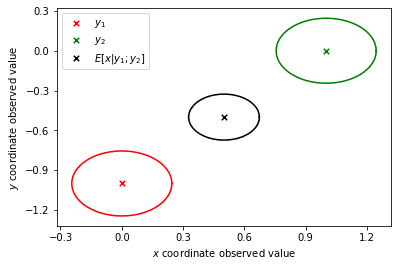

C:\Users\NITISH SHARMA\.pyenv\pyenv-win\versions\3.9.10\lib\site-packages\probml_utils\plotting.py:79: UserWarning: set FIG_DIR environment variable to save figures
  warnings.warn("set FIG_DIR environment variable to save figures")


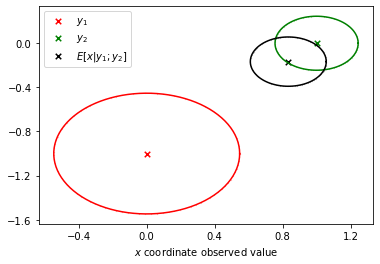

C:\Users\NITISH SHARMA\.pyenv\pyenv-win\versions\3.9.10\lib\site-packages\probml_utils\plotting.py:79: UserWarning: set FIG_DIR environment variable to save figures
  warnings.warn("set FIG_DIR environment variable to save figures")


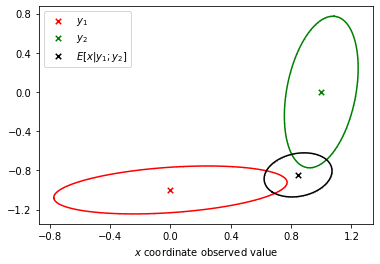

In [8]:
gen_data(sensorf_parm_dict)

In [9]:
interact_parm_dict = {"Fig_interact": {"save_name": "", "sigma": []}}

In [10]:
from ipywidgets import Layout, interact
import ipywidgets as widgets


@interact(
    sigma_1=widgets.FloatSlider(
        description="sigma 1",
        min=0.01,
        max=0.2,
        value=0.01,
        step=0.01,
        style=dict(description_width="initial"),
        layout=Layout(width="40%"),
        continuous_update=False,
    ),
    sigma_2=widgets.FloatSlider(
        description="sigma 2",
        min=0.01,
        max=0.2,
        value=0.01,
        step=0.01,
        style=dict(description_width="initial"),
        layout=Layout(width="40%"),
        continuous_update=False,
    ),
    option=widgets.ToggleButtons(
        options=["Spherical", "Unequal"],
        description="Gaussian Bayes:",
        disabled=False,
        style=dict(description_width="initial"),
        button_style="info",
    ),
)
def update(sigma_1, sigma_2, option):

    if option == "Spherical":
        interact_parm_dict["Fig_interact"]["sigma"] = [
            sigma_1 * jnp.eye(2),
            sigma_2 * jnp.eye(2),
        ]
    else:
        interact_parm_dict["Fig_interact"]["sigma"] = [
            sigma_1 * jnp.array([[10, 1], [1, 1]]),
            sigma_2 * jnp.array([[1, 1], [1, 10]]),
        ]

    gen_data(interact_parm_dict)

interactive(children=(FloatSlider(value=0.01, continuous_update=False, description='sigma 1', layout=Layout(wi…